In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np

from IPython import display

import tensorflow as tf
import tensorflow.keras.layers as nn


In [3]:
tf.__version__

'2.0.0'

In [4]:
def get_dataset(batch_size):
    (train_data, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    train_data = train_data.reshape([-1, 28, 28, 1]).astype('float32')
    train_data = train_data / 127.5 - 1
    dataset = tf.data.Dataset.from_tensor_slices(train_data).cache()
    dataset = dataset.shuffle(len(train_data)).batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

In [5]:
def plot_samples(samples, nrows=4):
    if not isinstance(samples, np.ndarray):
        images = samples.numpy()
    images = samples
    num_cols = images.shape[0] // nrows
    fig, ax = plt.subplots(nrows=nrows, ncols=num_cols)
    for i in range(4):
        for j in range(num_cols):
            ax[i, j].set_axis_off()
            ax[i, j].imshow(images[i * num_cols + j, :, :, -1], cmap='gray')

In [6]:
def get_generator(noise_dim=64):
    # DC-GAN like architecture
    z = tf.keras.Input(shape=(noise_dim,))
    # n_dim -> 256*7*7
    x = nn.Dense(256*7*7)(z)
    #x = nn.BatchNormalization()(x),
    #x = nn.LeakyReLU()(x)
    # 256*7*7 -> (7, 7, 256)
    x = nn.Reshape((7, 7, 256))(x)
    
    # (7, 7, 256) -> (14, 14, 128)
    x = nn.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = nn.BatchNormalization()(x)
    x = nn.LeakyReLU(alpha=0.01)(x)
    
    # (14, 14, 128) -> (14, 14, 64)
    x = nn.Convolution2DTranspose(64, kernel_size=3, strides=1, padding='same')(x)
    x = nn.BatchNormalization()(x)
    x = nn.LeakyReLU(alpha=0.01)(x)
    
    # (14, 14, 64) -> (28, 28, 1)
    x = nn.Convolution2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)
    output = nn.Activation('tanh')(x)
    
    model = tf.keras.Model(inputs=z, outputs=output)
    return model

In [7]:
def get_discriminator():
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = nn.Conv2D(64, kernel_size=5, strides=2, padding='same', use_bias=False)(inputs)
    x = nn.LeakyReLU()(x)
    x = nn.Dropout(0.5)(x)
    
    x = nn.Conv2D(128, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = nn.LeakyReLU()(x)
    x = nn.Dropout(0.5)(x)
    
    x = nn.Conv2D(128, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = nn.LeakyReLU()(x)
    x = nn.Dropout(0.5)(x)
    
    x = nn.Flatten()(x)
    out = nn.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=out)
    return model

In [8]:
def compute_generator_loss(fake_scores):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_scores), 
                                                   logits=fake_scores)
    return tf.nn.compute_average_loss(loss)


def compute_discriminator_loss(real_scores, fake_scores):
    loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_scores),
                                                        logits=real_scores)
    loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_scores),
                                                        logits=fake_scores)
    loss = loss_real + loss_fake
    return tf.nn.compute_average_loss(loss)

In [9]:
def process_batch(batch, generator, discriminator, generator_optimizer, discriminator_optimizer):
    bs, *_ =  tf.shape(batch)
    noise = tf.random.normal(shape=[BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        fake_images = generator(noise, training=True)
        real_scores = discriminator(batch, training=True)
        fake_scores = discriminator(fake_images, training=True)
        generator_loss = compute_generator_loss(fake_scores)
        discriminator_loss = compute_discriminator_loss(real_scores, fake_scores)
    
    discriminator_gradients = tape_d.gradient(discriminator_loss, discriminator.trainable_variables)
    generator_gradients = tape_g.gradient(generator_loss, generator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return discriminator_loss, generator_loss

In [10]:
def generate_images(generator, num_samples=16):
    noise = tf.random.normal([num_samples, NOISE_DIM])
    generated_images = generator(noise, training=False)
    return generated_images

In [11]:
import time

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Epoch 0.
Time elapsed: 89.58016800880432
Genrator loss: 0.6111448407173157
Discriminator loss: 0.6111448407173157


AttributeError: 'Mean' object has no attribute 'reset_state'

<Figure size 432x288 with 0 Axes>

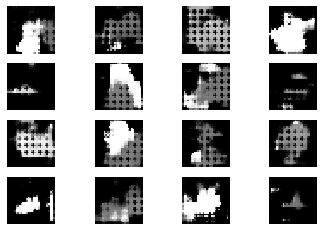

In [17]:
# Training procedure
EPOCHS = 150
BATCH_SIZE = 32
NOISE_DIM = 100

dataset = get_dataset(BATCH_SIZE)

generator = get_generator(noise_dim=NOISE_DIM)
generator_optimizer = tf.keras.optimizers.Adam(1e-3)

discriminator = get_discriminator()
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

mean_discriminator_loss = tf.keras.metrics.Mean()
mean_generator_loss = tf.keras.metrics.Mean()

for epoch in range(EPOCHS):
    display.clear_output(wait=True)
    print(f"Epoch {epoch}.")
    s_time = time.time()
    for batch in dataset:
        generator_loss, discriminator_loss = process_batch(batch, 
                                                           generator, 
                                                           discriminator,
                                                           generator_optimizer,
                                                           discriminator_optimizer)
        mean_discriminator_loss.update_state([discriminator_loss])
        mean_generator_loss.update_state([generator_loss])
        #print(f"Generator loss: {generator_loss:.4f}. Discriminator loss: {discriminator_loss:.4f}")
    e_time = time.time()
    generated_images = generate_images(generator)
    plt.clf()
    plot_samples(generated_images)
    print(f"Time elapsed: {e_time - s_time}")
    print(f"Genrator loss: {mean_generator_loss.result().numpy()}\n" \
          f"Discriminator loss: {mean_generator_loss.result().numpy()}")
    mean_generator_loss.reset_state()
    mean_discriminator_loss.reset_state()
    print("Image samples")
    display.display(plt.gcf())

In [14]:
generator_loss.numpy()

1.3909972

In [15]:
generated_images = generate_images(generator)
plot_samples(generated_iamges)